<a href="https://colab.research.google.com/github/nagamamo/financial_data_science/blob/main/9_2_fx_asset_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#[1]ライブラリの読み込み
import pandas_datareader as data
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
#[2]時系列データの単位根検定のライブラリ
import statsmodels.api as sm #全般的な時系列分析のライブラリ
from statsmodels.tsa.stattools import adfuller #ADF検定用ライブラリ

In [3]:
#[3]機械学習用ライブラリの読み込み
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split #学習・テストデータ分割のライブラリ
from sklearn.metrics import r2_score #決定係数による評価ライブラリ
from sklearn.metrics import mean_squared_error #平均二乗誤差による評価ライブラリ

In [4]:
#[4]為替レートデータの取得
USDJPY=data.DataReader('DEXJPUS','fred',start="2013-01-01",end="2022-12-31")
USDJPY.reset_index(inplace=True) #データフレーム統合のため変数名リセット
USDJPY2 = USDJPY.rename(columns={'DATE': 'Date','DEXJPUS': 'Yen'}) #新変数名定義

In [5]:
#[5]金利データの取得
tickers=['10USY.B','10JPY.B']
#df=data.data.DataReader(symbols=symbols,start='01/01/13',end='12/31/22').read().sort_values(by='Date',ascending=True)
df=data.DataReader(tickers,'stooq',start='01/01/13',end='12/31/22').sort_values(by='Date',ascending=True)
all_df = df['Close'] #日次終値をデータフレームに定義
all_df.reset_index(inplace=True)#データフレーム統合のため変数名リセット
all_df2 = all_df.rename(columns={'Date': 'Date','10USY.B': '10USB','10JPY.B': '10JPB'})#新変数名定義

In [6]:
#[6]データフレームの統合
US_Japan=pd.merge(USDJPY2,all_df2,how="inner",on="Date") #データフレームの統合
#data["Date"] = pd.to_datetime(data["Date"]) #日時をインデックス化のためdatetimeへ変換
US_Japan = US_Japan.set_index("Date")#日時をインデックスへ変換

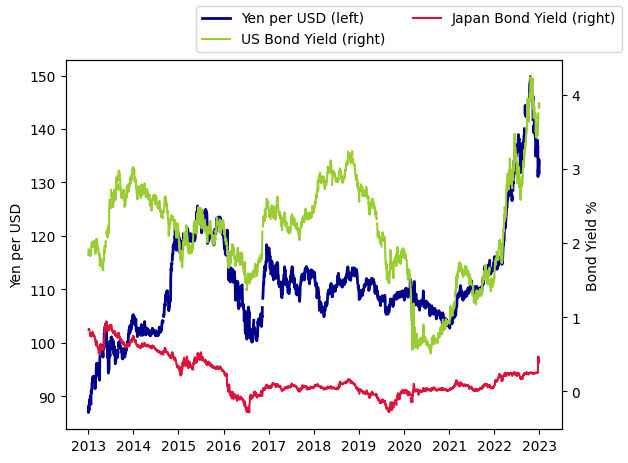

In [7]:
#[7]データの可視化
fig = plt.figure()
ax1 = fig.subplots()
ax2 = ax1.twinx()
#ax1.plot(US_Japan['Date'], US_Japan['Yen'], lw=2, color="darkblue",label="Yen per USD (left)")
#ax2.plot(US_Japan['Date'], US_Japan['10USB'], c="yellowgreen",label="US Bond Yield (right)")
#ax2.plot(US_Japan['Date'], US_Japan['10JPB'], c="crimson",label="Japan Bond Yield (right)")
ax1.plot(US_Japan['Yen'], lw=2, color="darkblue",label="Yen per USD (left)")
ax2.plot(US_Japan['10USB'], c="yellowgreen",label="US Bond Yield (right)")
ax2.plot(US_Japan['10JPB'], c="crimson",label="Japan Bond Yield (right)")
plt.ylabel('Yen per USD')
ax1.set_ylabel('Yen per USD')
ax2.set_ylabel('Bond Yield %')
fig.legend(ncol=2)
plt.show()

In [8]:
US_Japan=US_Japan.resample('M').last().dropna() #日次データの月次データへの変換と欠損値除去

In [9]:
#[8]採用変数の算出と定義
US_Japan['d_interest']=US_Japan['10USB']-US_Japan['10JPB'] #日米長期金利差の算出
US_Japan['d_Yen']=US_Japan['Yen'].pct_change()*100#為替レート前日比の算出
US_Japan=US_Japan.dropna()#欠損値の除去
X=US_Japan['d_interest'].values #説明変数の定義
Y=US_Japan['d_Yen'].values #被説明変数の定義

In [ ]:
#[9]時系列データの単位根検定
#sm.tsa.stattools.adfuller(Y, regression='c') #為替レート変化率の単位根検定
sm.tsa.stattools.adfuller(X, regression='c') #金利スプレッドの単位根検定

In [12]:
#[10]アセット・アプローチ・モデルの推計と機械学習
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)#学習データとテストデータの分割
model=LinearRegression(fit_intercept=True,copy_X=True,n_jobs=1,positive=False)#推計方法の定義①
model.fit(X_train.reshape(-1,1),Y_train.reshape(-1,1))#推計方法の定義②
Y_train_pred=model.predict(X_train.reshape(-1,1))#学習データによる予測値の算出
Y_test_pred=model.predict(X_test.reshape(-1,1))#テストデータによる予測値の算出

係数値: 0.56347 定数項: -0.76423
決定係数: 0.02134


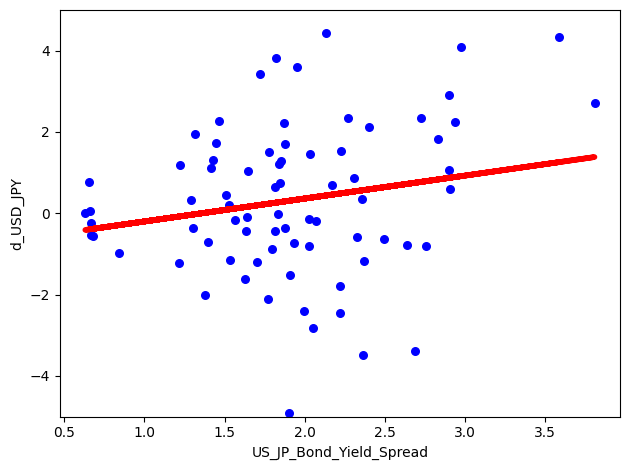

In [13]:
#[11]推計結果と可視化
print('係数値: %.5f' % model.coef_,'定数項: %.5f' %model.intercept_)#係数値と定数項
print('決定係数: %.5f' %model.score(X_train.reshape(-1,1),Y_train.reshape(-1,1)))#決定係数
plt.scatter(X_train.reshape(-1,1),Y_train,c='blue',s=30)
plt.plot(X_train.reshape(-1,1),Y_train_pred,color='red',lw=4)
plt.xlabel('US_JP_Bond_Yield_Spread')
plt.ylabel('d_USD_JPY')
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

In [14]:
#[11]機械学習の評価
print('RMSE 学習: %.4f, テスト: %.4f' %(mean_squared_error(Y_train,Y_train_pred,squared=False),mean_squared_error(Y_test,Y_test_pred,squared=False)))#平方二乗誤差の評価
print('R2 学習: %.4f, テスト: %.4f' %(r2_score(Y_train,Y_train_pred),r2_score(Y_test,Y_test_pred)))#決定係数の評価

RMSE 学習: 2.4849, テスト: 2.7096
R2 学習: 0.0213, テスト: -0.0721


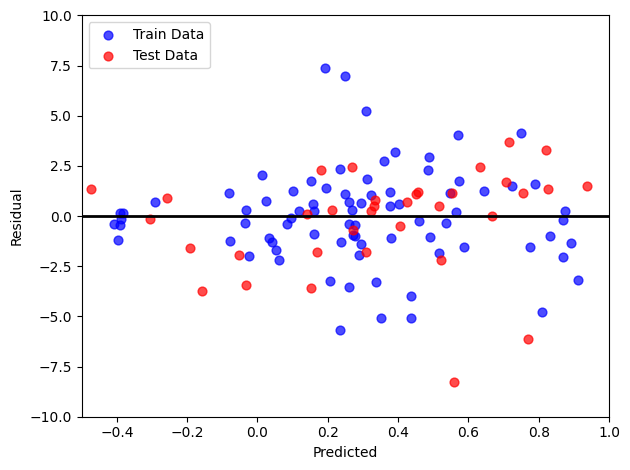

In [15]:
#[12]機械学習結果の可視化
plt.scatter(Y_train_pred,Y_train_pred-Y_train.reshape(-1,1),c='blue',marker='o',s=40,alpha=0.7,label='Train Data')
plt.scatter(Y_test_pred,Y_test_pred-Y_test.reshape(-1,1),c='red',marker='o',s=40,alpha=0.7,label='Test Data')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-1,xmax=1,lw=2,color='black')
plt.xlim([-0.5,1])
plt.ylim([-10,10])
plt.tight_layout()
plt.show()